In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from scipy.io import arff
import xgboost as xgb

from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, recall_score, precision_score, plot_precision_recall_curve, mean_squared_error, r2_score, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
import category_encoders as ce
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import metrics

from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.svm import SVC

from skopt import BayesSearchCV, plots

from google.auth.transport.requests import Request
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build

from time import sleep 

import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

from watcher import entries_processed

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

np.random.seed(123)

#import credencials
from cred import key, email, password

# Data preprocessing

## Wczytanie danych

In [5]:
df = pd.read_csv("students-all.csv")
# remove rownames
df = df.iloc[:,1:]

In [6]:
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,major_por
0,18,4,4,2,2,0,4,3,4,1,1,3,6,5,6,6,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0
1,17,1,1,1,2,0,5,3,3,1,1,3,4,5,5,6,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
2,15,1,1,1,2,3,4,3,2,2,3,3,10,7,8,10,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,1,0,0
3,15,4,2,1,3,0,3,2,2,1,1,5,2,15,14,15,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,1,1,1,1,1,0
4,16,3,3,1,2,0,4,3,2,1,2,5,4,6,10,10,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0


## Funkcja trenująca na xgboost
Warto zauważyć, że train_fast imituje crossvalidation czyli dzieli zbiór na części. Wobec tego należy być ostrożnym przy jej używaniu by nie podzielić na np. 70 - 30 train/test , potem train fast dzieli na 5 foldów, w wyniku czego model uczy się na 14% oryginalego zbioru.

In [7]:
def train_fast(df, max_depth, target ):
    
    """
    From Standard cross validation differs in data partitnion. Due to optimizing model on validation set,
    we get final AUC score from equally big test set.
    """
    
    # shuffling index
    df = df.sample(frac=1).reset_index(drop=True)
    n = len(df)
    
    # 5 fold cross validation
    kf = KFold(n_splits=5)
        
    
    ret = []
    tpr_arr = []
    fpr_arr = []
    
    # we will make test 10% and validation 10%
    for train_index, test_index in kf.split(df):
        
        train = df.iloc[train_index,:]
        
        v_ind = test_index[0:(len(test_index)//2)] 
        t_ind = test_index[(len(test_index)//2):len(test_index)]
        
        validation = df.iloc[v_ind,:]
        test = df.iloc[t_ind,:]
        
        label_train = train[target]
        label_val = validation[target]
        label_test = test[target]

        df_train = train.drop([target], axis = 1)
        df_test  = test.drop([target], axis = 1)
        df_val  = validation.drop([target], axis = 1)
        
        dtrain = xgb.DMatrix(data = df_train, label=label_train)
        dval = xgb.DMatrix(data = df_val, label=label_val)
        dtest = xgb.DMatrix(data = df_test, label=label_val)
        
        param = {'max_depth': max_depth, 'objective': 'binary:logistic', 'eval_metric':'auc'}
        
        evallist = [(dval, 'eval'), (dtrain, 'train')]
        
        num_round = 100
        
        bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=0)
        y_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

        fpr, tpr, thresholds = metrics.roc_curve(label_test.to_numpy(), y_pred)

        
        ret.append(metrics.auc(fpr, tpr))
        
        fpr_arr.append(fpr)
        tpr_arr.append(tpr)
        
    # fpr and tpr arrays are problematic, we will get them from median AUC score
    # note that we are returning mean auc score, so it is not ideal 
    index = np.where(np.mean(np.array(ret))== np.mean(np.array(ret)))[0][0]
    
    
    return np.array(ret).mean(), bst, fpr_arr[index],tpr_arr[index]

## Uśrednione auc

In [8]:
def get_auc_mean(df, max_depth, target = "romantic_yes", n = 10):
    auc_sum = 0
    for i in range(n):
        auc, bst, _, _ = train_fast(df, max_depth, target)
        auc_sum += auc
    return auc_sum/n

Zobaczmy jak zachowuje się xgboost przy różnych parametrach max_depth. Może chwilę potrwać

In [9]:
%%capture
auc_results = []

for i in range(40): 
    auc = get_auc_mean(df_dummies, i, "romantic_yes")
    auc_results.append(auc)

In [10]:
# Zróbmy średnią kroczącą 
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [11]:
a = moving_average(np.array(auc_results),5)

Text(0.5, 1.0, 'auc based on max_depth')

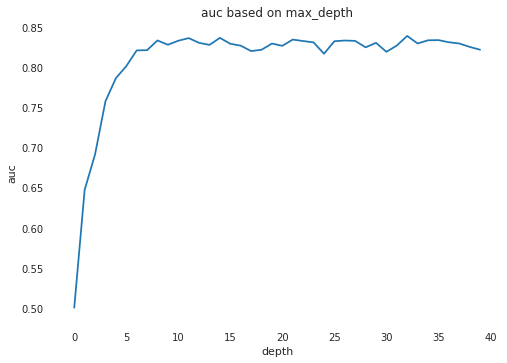

In [12]:
res = pd.DataFrame({"auc": auc_results, "depth": [i for i in range(40)]})
sns.lineplot(data = res, x = "depth", y = "auc").set_title("auc based on max_depth")

Text(0.5, 1.0, 'moving average of auc, base = 5')

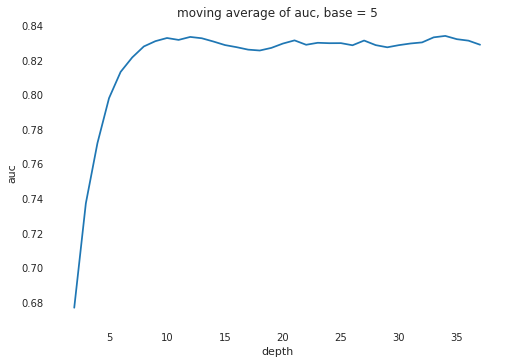

In [13]:
res = pd.DataFrame({"auc":a,"depth":np.arange(len(auc_results))[2:-2]})
sns.lineplot(data = res, x = "depth", y = "auc").set_title("moving average of auc, base = 5")

Jak widać od depth około 6 otrzymujemy średnio to samo AUC

## Różne encodery
Przetestujmy jak działają różne enkodery na naszym modelu - czy ktoreś będą bardzo polepszały auc?

In [14]:
df['romantic'] = np.where(df['romantic']=='yes', 1, 0)
y = df[['romantic']].copy()
df = df.drop(columns='romantic')

In [15]:
encolums = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'major']

In [16]:
%%capture
res_dict = {}
encoder = ce.backward_difference.BackwardDifferenceEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["BackwardDifferenceEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [17]:
%%capture
encoder = ce.binary.BinaryEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["BinaryEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [18]:
%%capture
encoder = ce.basen.BaseNEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["BaseNEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [19]:
%%capture
encoder = ce.hashing.HashingEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["HashingEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [20]:
%%capture
encoder = ce.helmert.HelmertEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["HelmertEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [21]:
%%capture
encoder = ce.one_hot.OneHotEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["OneHotEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [22]:
%%capture
encoder = ce.ordinal.OrdinalEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["OneHotEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [23]:
%%capture
encoder = ce.polynomial.PolynomialEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["OneHotEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

In [24]:
%%capture
encoder = ce.sum_coding.SumEncoder(cols = encolums)
df_encoded = encoder.fit_transform(df)
df_encoded['romantic'] = y
res_dict["OneHotEncoder"] = get_auc_mean(df_encoded, 18, "romantic")

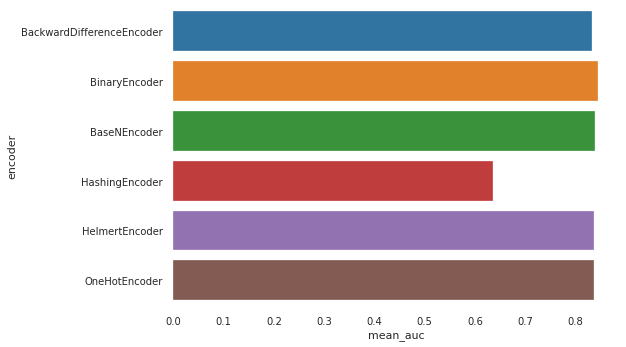

In [25]:
res_df = pd.DataFrame({"encoder": list(res_dict.keys()), "mean_auc": list(res_dict.values())})
sns.barplot(data = res_df, y = "encoder", x = "mean_auc")

In [26]:
from pprint import pprint
pprint(res_df)

                     encoder  mean_auc
0  BackwardDifferenceEncoder  0.833543
1              BinaryEncoder  0.845554
2               BaseNEncoder  0.838845
3             HashingEncoder  0.636498
4             HelmertEncoder  0.836377
5              OneHotEncoder  0.836121


Najlepiej radzi sobie one_hot_encoder, w kolejnych obliczeniach używać będziemy jego i jego najbliższego kuzyna `dummies`

## Logarytmowanie zmiennych ciągłych

Zobaczmy czy zlogarytmowanie pewnych zmiennych - na przykład obecności, które nijak nie przypominają rozkłady normalnego da pozytywny skutek.

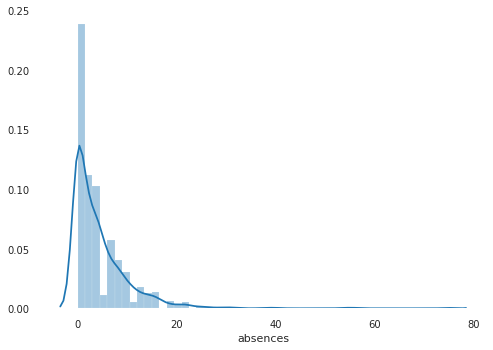

In [27]:
sns.distplot(df_dummies.absences)

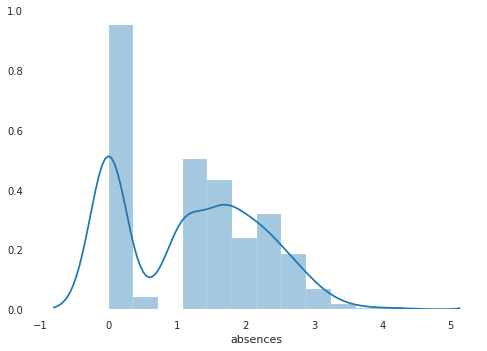

In [28]:
sns.distplot(np.log(df_dummies.absences+1)) 

In [29]:
df_dummies["absences"] = np.log(df.absences +1)

In [30]:
get_auc_mean(df_dummies, 19)

0.8236201757930403

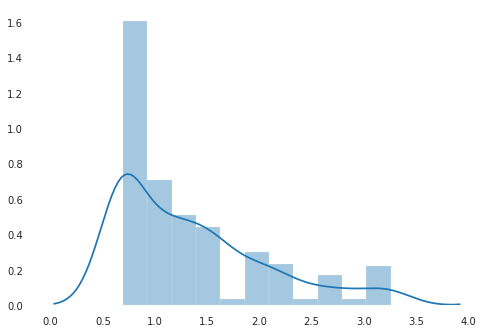

In [31]:
sns.distplot(np.log(df_dummies.loc[df_dummies.romantic_yes == 1].Walc * df_dummies.loc[df_dummies.romantic_yes == 1].Dalc + 1))

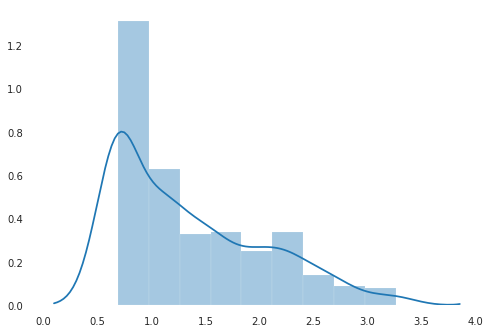

In [32]:
sns.distplot(np.log(df_dummies.loc[df_dummies.romantic_yes == 0].Walc * df_dummies.loc[df_dummies.romantic_yes == 0].Dalc +1))

Spróbujmy stworzyć nowe zmienne i zobaczmy czy da to lepszy wynik
 * WeekandEnd
 * WeirdDrinker

In [33]:
df_dummies["WeekandEnd"] = np.log(df_dummies.Walc * df_dummies.Dalc +1)

In [34]:
get_auc_mean(df_dummies, 19)  # idziemy do przodu

0.8275404807784629

In [35]:
a = np.where((df_dummies.Dalc > 3)&(df_dummies.Walc <3),1,0 )   # wniosek z eda, osoby oznaczone w tej kolumnie jako 1, to wyłącznie romantycy
df_dummies["WeirdDrinker"] = a

In [36]:
get_auc_mean(df_dummies,19)      # porównywalnie z ostatnią

0.8236886419768071

Wynik prównywalny z ostatnią

## PCA
Zobaczmy czy widać coś graficznie.

In [37]:
pca = PCA(n_components=10) 
X = preprocessing.normalize(df_dummies.drop("romantic_yes", axis = 1), norm='l2')

principalComponents = pca.fit_transform(X)

cols = []
for i in range(10): 
    cols.append("pc"+str(i+1))

principalDf = pd.DataFrame(data = principalComponents, columns = cols)
principalDf

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,0.291357,-0.002310,-0.068397,-0.104919,0.132940,-0.017787,-0.000859,-0.005117,0.019692,0.029364
1,0.293148,-0.014608,-0.150127,-0.030610,0.003750,-0.047458,0.017834,0.000423,0.035776,-0.037097
2,0.065921,-0.117237,-0.074609,0.000286,-0.021265,0.022723,0.022138,-0.010900,-0.018566,-0.054670
3,-0.190891,0.069406,0.031124,-0.042401,-0.026170,0.030764,0.026880,-0.022322,0.008727,0.018381
4,0.058324,-0.061050,-0.065479,-0.137130,0.010415,0.032583,-0.062040,-0.007676,0.000336,-0.006266
...,...,...,...,...,...,...,...,...,...,...
1039,0.076266,0.019750,-0.048860,-0.049729,-0.027928,0.011573,-0.026541,-0.009373,-0.017060,-0.026426
1040,-0.157430,0.026529,-0.045728,0.067681,0.041066,-0.023296,0.014745,-0.011721,0.005191,0.007356
1041,0.012407,0.073764,-0.076956,0.019303,-0.081741,0.139707,-0.014794,-0.072000,-0.014485,0.044567
1042,0.055787,-0.105886,0.039204,0.093806,0.034677,0.004991,0.009567,-0.022203,-0.032627,0.034219


In [38]:
pca.explained_variance_ratio_.cumsum()   # 55 % wariancji w 2 ważnych kolumnach

array([0.48064371, 0.55648099, 0.61878967, 0.66826408, 0.71678488,
       0.75103801, 0.78087927, 0.80322883, 0.82247856, 0.84129384])

zredukowaliśmy wymiar do 10

In [39]:
pca_df = pd.concat([principalDf,df_dummies.romantic_yes],axis =1)
pca_df

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,romantic_yes
0,0.291357,-0.002310,-0.068397,-0.104919,0.132940,-0.017787,-0.000859,-0.005117,0.019692,0.029364,0
1,0.293148,-0.014608,-0.150127,-0.030610,0.003750,-0.047458,0.017834,0.000423,0.035776,-0.037097,0
2,0.065921,-0.117237,-0.074609,0.000286,-0.021265,0.022723,0.022138,-0.010900,-0.018566,-0.054670,0
3,-0.190891,0.069406,0.031124,-0.042401,-0.026170,0.030764,0.026880,-0.022322,0.008727,0.018381,1
4,0.058324,-0.061050,-0.065479,-0.137130,0.010415,0.032583,-0.062040,-0.007676,0.000336,-0.006266,0
...,...,...,...,...,...,...,...,...,...,...,...
1039,0.076266,0.019750,-0.048860,-0.049729,-0.027928,0.011573,-0.026541,-0.009373,-0.017060,-0.026426,0
1040,-0.157430,0.026529,-0.045728,0.067681,0.041066,-0.023296,0.014745,-0.011721,0.005191,0.007356,0
1041,0.012407,0.073764,-0.076956,0.019303,-0.081741,0.139707,-0.014794,-0.072000,-0.014485,0.044567,0
1042,0.055787,-0.105886,0.039204,0.093806,0.034677,0.004991,0.009567,-0.022203,-0.032627,0.034219,0


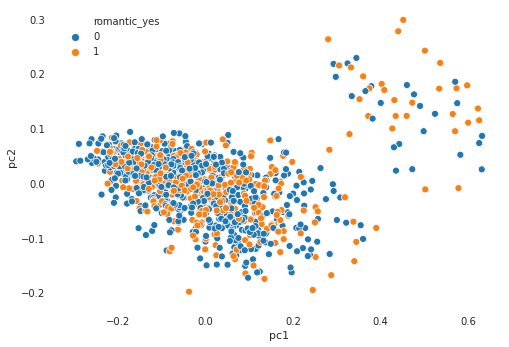

In [40]:
sns.scatterplot(x = "pc1", y = "pc2", data = pca_df, hue = "romantic_yes")  

Nie widać widocznego podziału danych

In [41]:
get_auc_mean(pca_df, 19)

0.6304147943433231

Czyli najlepsze średnie AUC dostaliśmy po przekształceniach
ramki danych logarytmicznie i eksponując niektóre zależności

Ponowne wczytanie danych

In [42]:
df = pd.read_csv("students-all.csv")
# remove rownames
df = df.iloc[:,1:]
df['romantic'] = np.where(df['romantic']=='yes', 1, 0)
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies.head()

,age,Medu,Fedu,traveltime,studytime,failures,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,major_por
0,18,4,4,2,2,0,0,4,3,4,1,1,3,6,5,6,6,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0
1,17,1,1,1,2,0,0,5,3,3,1,1,3,4,5,5,6,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0
2,15,1,1,1,2,3,0,4,3,2,2,3,3,10,7,8,10,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,1,1,0
3,15,4,2,1,3,0,1,3,2,2,1,1,5,2,15,14,15,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,1,1,1,1,0
4,16,3,3,1,2,0,0,4,3,2,1,2,5,4,6,10,10,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0


In [43]:
df_dummies = df_dummies.sample(frac =1)

Po zastanowieniu doszliśmy do wniosku, że chcielibyśmy zobaczyć jak różne enkodery działają na różnych modelach, by móc zdecydować się na ostateczny wybór modelu, który chcemy zastosować.

In [44]:
def measure_encoder(encoder, model):
    """
    Funkcja działająca jako pipeline w następujących krokach:
    * kodowanie
    * dopasowanie
    * liczenie roc_auc_score
    """
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['romantic'], axis = 1),df.romantic, test_size = 0.3, random_state = 66)
    
    encoder.fit(X_train, y_train)
    
    X_train = encoder.transform(X_train)
    X_test = encoder.transform(X_test)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    auc = roc_auc_score(y_test, y_pred)
    
    return auc

In [45]:
columns= ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'major']

Wszystkie możliwe encodery

In [46]:
enc = [ce.BackwardDifferenceEncoder(cols=columns),
ce.BaseNEncoder(cols=columns),
ce.BinaryEncoder(cols=columns),
ce.CatBoostEncoder(cols=columns),
ce.HashingEncoder(cols=columns),
ce.HelmertEncoder(cols=columns),
ce.JamesSteinEncoder(cols=columns),
ce.LeaveOneOutEncoder(cols=columns),
ce.MEstimateEncoder(cols=columns),
ce.OneHotEncoder(cols=columns),
ce.OrdinalEncoder(cols=columns),
ce.SumEncoder(cols=columns),
ce.PolynomialEncoder(cols=columns),
ce.TargetEncoder(cols=columns),
ce.WOEEncoder(cols=columns)]

In [47]:
def measure_encodesrs(model):
    res = pd.DataFrame()
    names = ['BackwardDifferenceEncoder',
            'BaseNEncoder',
            'BinaryEncoder',
            'CatBoostEncoder',
             'HashingEncoder',
             'HelmertEncoder',
             'JamesSteinEncoder',
             'LeaveOneOutEncoder',
             'MEstimateEncoder',
             'OneHotEncoder',
             'OrdinalEncoder',
             'SumEncoder',
             'PolynomialEncoder',
             'TargetEncoder',
             'WOEEncoder'
            ]
    for i in range(len(enc)):
        auc = measure_encoder(enc[i], model)
        res = res.append({"Name": names[i], "auc": auc}, ignore_index = True)
    return res

Modele, które rozważamy do klasyfikacji 

In [48]:
models = [AdaBoostClassifier(), 
          BaggingClassifier(), 
          ExtraTreesClassifier(),
          RandomForestClassifier(), 
          GradientBoostingClassifier(),
          XGBClassifier(),
          XGBRFClassifier()]

In [49]:
r = []
for m in models:
    print(m)
    print(measure_encodesrs(m))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
                         Name       auc
0   BackwardDifferenceEncoder  0.547339
1                BaseNEncoder  0.554279
2               BinaryEncoder  0.554279
3             CatBoostEncoder  0.612314
4              HashingEncoder  0.508089
5              HelmertEncoder  0.589993
6           JamesSteinEncoder  0.612314
7          LeaveOneOutEncoder  0.612314
8            MEstimateEncoder  0.612314
9               OneHotEncoder  0.588004
10             OrdinalEncoder  0.547339
11                 SumEncoder  0.588004
12          PolynomialEncoder  0.560732
13              TargetEncoder  0.612314
14                 WOEEncoder  0.612314
BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose

Warto rozważyć i dostroić hiperparametry dla dwóch modeli z potencjałem - XGBClassifier i ExtraTreesClassifier.
Poniżej zastosowaliśmy BayesSearchCV by dostroić parametry dla tych modeli.

In [50]:
def on_step(optim_result):
    score = bsc.best_score_
    print("best score: %s" % score)
    return

In [51]:
encoder = ce.OneHotEncoder()

X = pd.read_csv("students-all.csv").iloc[:,1:]
y = X.romantic
X = X.drop("romantic", axis =1)

encoder.fit(X)
X = encoder.transform(X)

In [52]:
xgb_model = xgb.XGBClassifier()
extra_trees_model = ExtraTreesClassifier()

xgb_params = {
                "max_depth"         : np.arange(3,100),
                "learning_rate"     : np.arange(0.001,1,0.001, dtype = "float64"),
                "booster"           : ["gbtree","gblinear","dart"],
                "subsample"         : np.arange(0.1,1,0.1, dtype = "float64"),
                "colsample_bytree"  : np.arange(0.1,1,0.1, dtype = "float64"),
                "reg_alpha"         : np.arange(0,10,0.1, dtype = "float64"),
                "reg_lambda"        : np.arange(0,10,0.1, dtype = "float64")
}

extra_params = {
                    "min_samples_split" : np.arange(2,20,1),
                    "min_samples_leaf"  : np.arange(1,20,1),
                    "bootstrap" : [False,True],
                    "ccp_alpha" :  np.arange(0,10, 0.1)
                }




In [19]:
bsc = BayesSearchCV(extra_trees_model, extra_params, n_iter = 100, cv = 5)
bsc.fit(X,y, callback = on_step)


best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best score: 0.6446360153256705
best sco

BayesSearchCV(cv=5, error_score='raise',
              estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                             class_weight=None,
                                             criterion='gini', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=N...
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.

In [8]:
bsc = BayesSearchCV(xgb_model, xgb_params, n_iter = 200, cv = 5)
bsc.fit(X,y, callback = on_step)


best score: 0.6283524904214559
best score: 0.6724137931034483
best score: 0.6724137931034483
best score: 0.6724137931034483
best score: 0.6724137931034483
best score: 0.6724137931034483
best score: 0.6772030651340997
best score: 0.6772030651340997
best score: 0.6772030651340997
best score: 0.6772030651340997
best score: 0.6886973180076629
best score: 0.6886973180076629
best score: 0.6886973180076629
best score: 0.6886973180076629
best score: 0.6886973180076629
best score: 0.6886973180076629
best score: 0.7078544061302682
best score: 0.7078544061302682
best score: 0.7078544061302682
best score: 0.7078544061302682
best score: 0.7078544061302682
best score: 0.7327586206896551
best score: 0.7327586206896551
best score: 0.7327586206896551
best score: 0.7327586206896551
best score: 0.7327586206896551
best score: 0.7327586206896551
best score: 0.7327586206896551
best score: 0.7327586206896551
best score: 0.7327586206896551
best score: 0.7327586206896551
best score: 0.7327586206896551
best sco

BayesSearchCV(cv=5, error_score='raise',
              estimator=XGBClassifier(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, gamma=None,
                                      gpu_id=None, importance_type='gain',
                                      interaction_constraints=None,
                                      learning_rate=None, max_delta_step=None,
                                      max_depth=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      n_...
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4,
       6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 

In [9]:
bsc.best_params_

OrderedDict([('booster', 'dart'),
             ('colsample_bytree', 0.9),
             ('learning_rate', 0.461),
             ('max_depth', 47),
             ('reg_alpha', 0.0),
             ('reg_lambda', 1.1),
             ('subsample', 0.6)])

Model ten zapisaliśmy jako alco.model, żeby móc go potem bezproblemowo używać

In [53]:
xgb_model = xgb.XGBClassifier()
xgb_model.load_model('alco.model')

# Wyniki ostatecznego modelu

Wczytanie po raz kolejny danych, by na pewno były czyste i ich zenkodowanie.

In [54]:
df = pd.read_csv("students-all.csv")
# remove rownames
df = df.iloc[:,1:]

encoder = ce.OneHotEncoder()

df = pd.read_csv("students-all.csv").iloc[:,1:]
y = df.romantic
df = df.drop("romantic", axis =1)

df_one_hot = encoder.fit_transform(df)

target = np.where(y=='yes', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(df_one_hot,
                                                    target, test_size = 0.2, random_state = 666)

Zobaczmy ile wynosi auc:

In [55]:
y_predict_prob = xgb_model.predict_proba(X_test)[:,1]
y_pres = xgb_model.predict(X_test)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_predict_prob)

0.8041666666666667

## Features importance

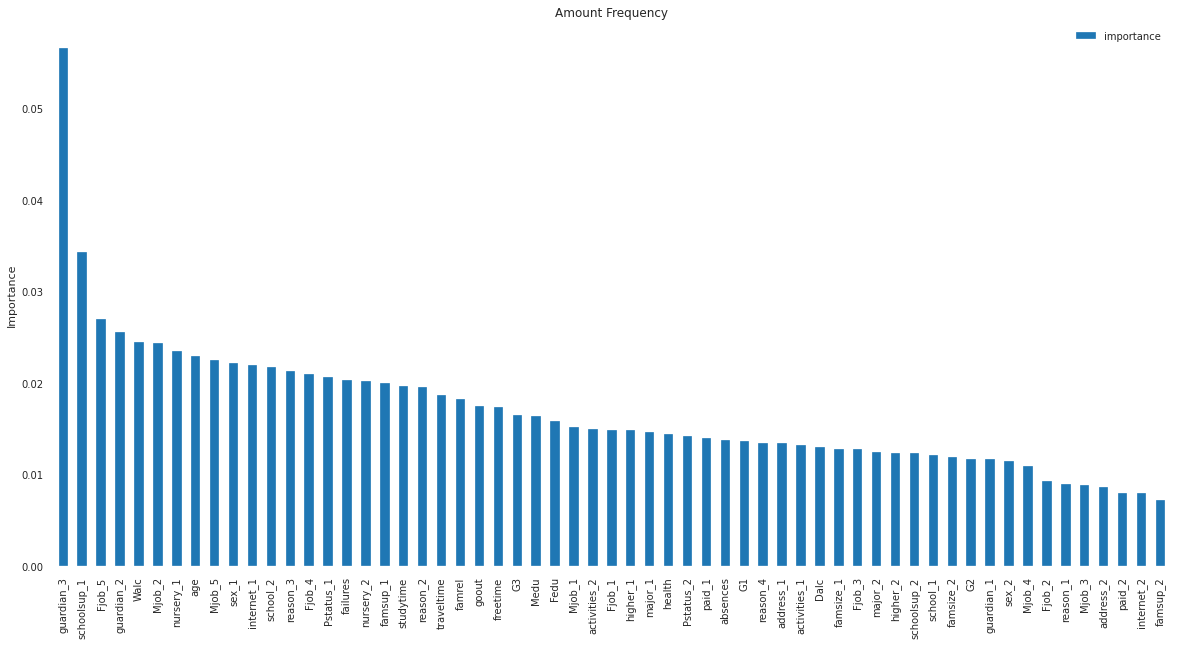

In [56]:
sorted_idx = np.argsort(xgb_model.feature_importances_)[::-1]
names = []
val = []
for index in sorted_idx:
    names.append(X_train.columns[index])
    val.append(xgb_model.feature_importances_[index])

d = pd.DataFrame({'feature':names, 'importance': val});
plt.rcParams['figure.figsize'] = [20, 10];
ax = d.plot(kind='bar', label = names);
ax.set_title('Amount Frequency');
ax.set_xlabel('');
ax.set_ylabel('Importance');
ax.set_xticklabels(names);

### Confusion matrix

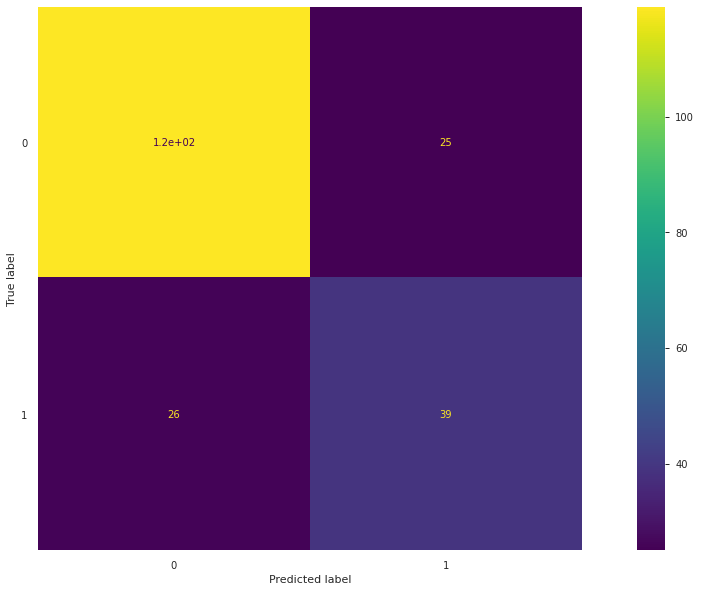

In [57]:
plot_confusion_matrix(xgb_model, X_test, y_test)

### Roc curve

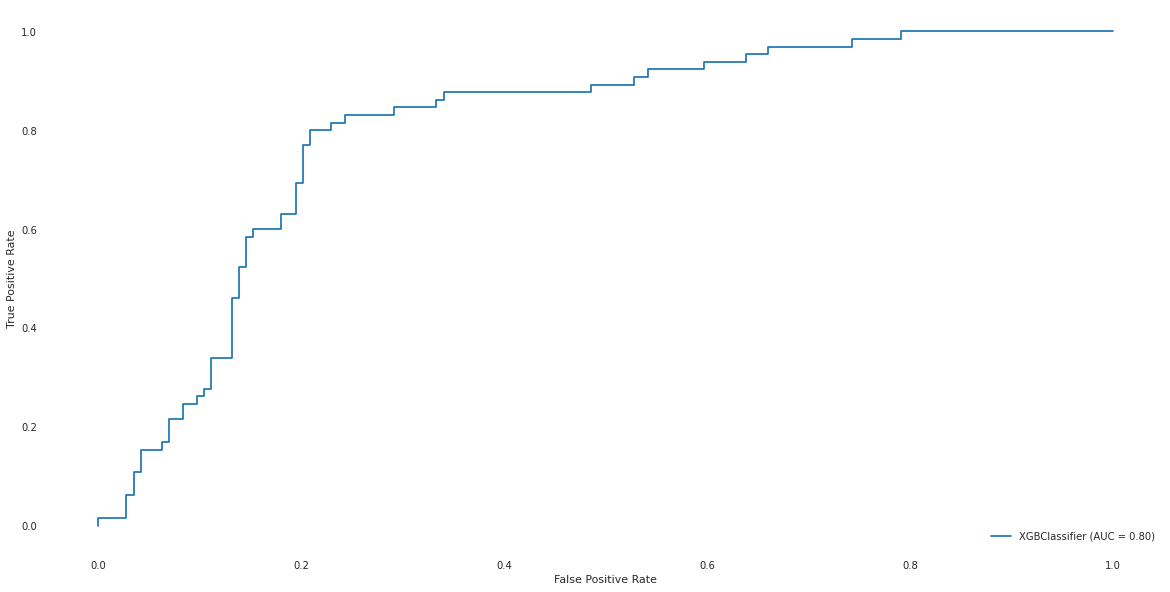

In [58]:
plot_roc_curve(xgb_model, X_test, y_test)

### Precision Recall curve

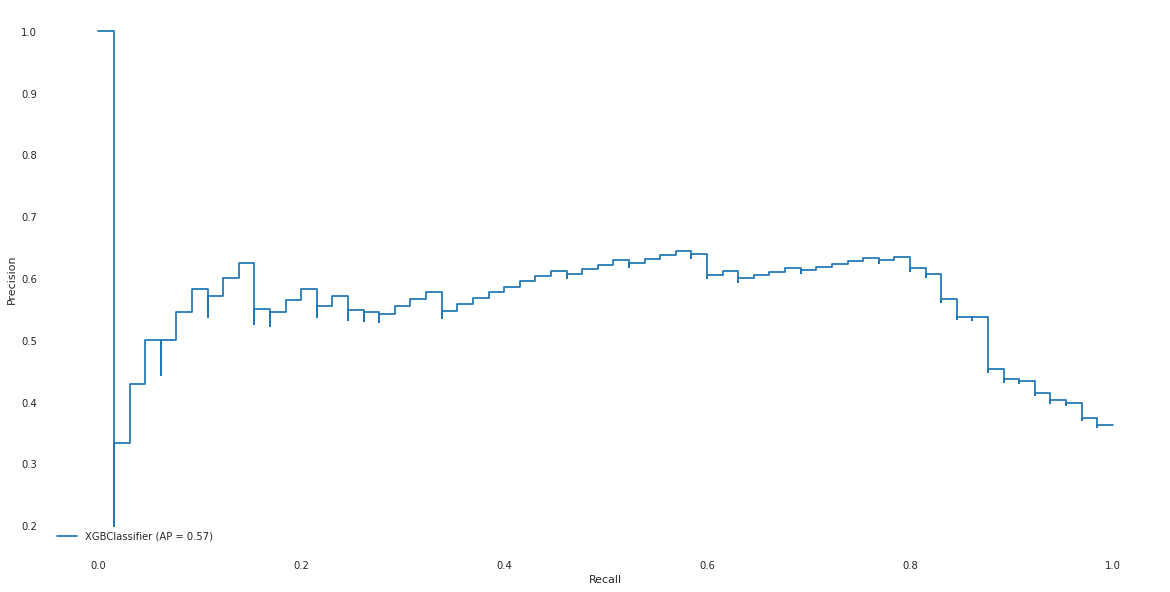

In [59]:
plot_precision_recall_curve(xgb_model, X_test, y_test)

## Ankieta w czasie rzeczywistym
Poniższy kod przedstawia budowę skryptu, który w czasie rzeczywistym przetwarza akietę (link)[https://docs.google.com/forms/d/e/1FAIpQLSdf2byFFOKvdps4FAR6ZQZbDuFN24LqqXO13Z_eZTYgxQKIdA/viewform]

Używa on klucza deweloperskiego, którego ze względów bezpieczeństwa i prywatności nie udostępnimy, niemniej jednak kod upubliczniamy ze wzgęldu na jego użyteczność.

In [60]:
def parse(data, encoder):
    """
    Parsing data to the same format as in "students-all.csv"
    
    returns: nicks, mails array and dataframe
    """
    nicks = np.array(data['Nick'])
    mails = np.array(data['Feedback mail'])
    data = data.iloc[:, 2:-1]

    column_names = [
        'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob',
        'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures',
        'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'internet',
        'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
        'G1', 'G2', 'G3'
    ]

    data.columns = column_names

    # deafults
    data['school'] = np.repeat("GP", data.shape[0])
    data['major'] = np.repeat("mat", data.shape[0])
    data['higher'] = np.repeat("yes", data.shape[0])

    # corect order
    data = data[[
        'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
        'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime',
        'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities',
        'nursery', 'higher', 'internet', 'famrel', 'freetime', 'goout', 'Dalc',
        'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'major'
    ]]
    
    data['age'] = pd.to_numeric(data['age'])
    data['sex'] = np.where(data.sex == 'Male', 'M', 'F')
    data['address'] = np.where(data.address == 'Rural', 'R', 'U')
    data['famsize'] = np.where(data.famsize == 'more than 3', 'GT3', 'LE3')
    data['Pstatus'] = np.where(data.Pstatus == 'living apart', 'A', 'T')

    d1 = {
        'none': 0,
        'primary education': 1,
        'middle school': 2,
        'high school': 3,
        'higher education': 4
    }

    data['Medu'] = [d1[item] for item in list(data.Medu)]
    data['Fedu'] = [d1[item] for item in list(data.Fedu)]

    d2 = {
        'teacher': 'teacher',
        'healthcare': 'health',
        'civil services': 'civil',
        'home': 'at_home',
        'other': 'other'
    }

    data['Mjob'] = [d2[item] for item in list(data.Mjob)]
    data['Fjob'] = [d2[item] for item in list(data.Fjob)]

    d3 = {
        'close to home': 'home',
        'school reputation': 'reputation',
        'course preference': 'course',
        'other': 'other'
    }

    data['reason'] = [d3[item] for item in list(data.reason)]
    
    d4 = {'Mother':'mother', 'Father':'father', 'other':'other'}
    
    data['guardian'] = [d4[item] for item in list(data.guardian)]

    d5 = {'< 15':1, '15-30':2, '30-60':3,'60 >':4}
    
    data['traveltime'] = [d5[item] for item in list(data.traveltime)]
    
    d6 = {'< 2':1, '2-5':2, '5-10':3,'10 >':4}
    
    data['studytime'] = [d6[item] for item in list(data.studytime)]
    
    data['G1'] = np.array(((pd.to_numeric(data.G1) -2 )/3)*20 , dtype = 'int64')
    data['G2'] = np.array(((pd.to_numeric(data.G2) -2 )/3)*20 , dtype = 'int64') 
    data['G3'] = np.array(((pd.to_numeric(data.G3) -2 )/3)*20 , dtype = 'int64')
    
    data['absences'] = np.array(pd.to_numeric(data.absences) , dtype = 'int64')
    data['failures'] = np.array(data.failures, dtype = 'int64')
    data['famrel']   = np.array(data.famrel, dtype = 'int64')
    data['freetime'] = np.array(data.freetime, dtype = 'int64')
    data['goout']    = np.array(data.goout, dtype = 'int64')
    data['Dalc']     = np.array(data.Dalc, dtype = 'int64')
    data['Walc']     = np.array(data.Walc, dtype = 'int64')
    data['health']   = np.array(data.health, dtype = 'int64')
    
    
    data_transformed = encoder.transform(data)
    
    return nicks, mails, data_transformed

In [61]:
def get_new_entries(entries_processed,
                    encoder,
                    rows = 5000, 
                    SAMPLE_SPREADSHEET_ID = '1e1tWLI0vD05bUj-wLWicOnl0iU-GWz0aaWEtRDlTQ2M'):
    """
    Ściąga i przetwarza nowe wiersze w arkuszu odpowiedzi od wiersza = entries_processed
    """
    
    cols = "AG"
    SAMPLE_RANGE_NAME = 'A1:'+ cols + str(rows)
    result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                range=SAMPLE_RANGE_NAME).execute()
    values = result.get('values', [])
    data = pd.DataFrame(values)
    data.columns = data.iloc[0,:]
    data = data.iloc[1+entries_processed:,:]
    print('Processing from rows: {}. Got {} new entries'.format(entries_processed, data.shape[0]))
    
    n,m,df = parse(data, encoder)
    return n,m,df

In [62]:
def predict_new_entries(df, model):
    """
    Przewiduje ramkę danych przed model - wrapper
    """
    
    y_predict = model.predict(df)
    y_predict_prob = model.predict_proba(df)[:,1]
    
    return y_predict, y_predict_prob

In [63]:
def send_response(nick, send_to_email, result, prob):
    """
    wysyła mail do adresata
    """
    
    # dane prywatne 
    global email, password
    subject = "Student, do you have partner?"
    message = 'Hi, {}'.format(nick)
    message += "\n\nThank you for participating in our survey! Here are your results: "

    if result == 0:
        message += '\nForever alone'
    else:
        message += '\nYou have partner!'
    
    message += '\nYour probability of being in romantic relationship is: {}'.format(prob)
    message += '\n\nThis result was predicted by machine learning model trained on Student Alcohol Consumption dataset from University Of Camerino'
    
    message += '\n\nSee you next time!'
    
    msg = MIMEMultipart()
    msg["From"] = email
    msg["To"] = send_to_email
    msg["Subject"] = subject

    msg.attach(MIMEText(message, 'plain'))

    try: 
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.starttls()
        server.login(email, password)
        text = msg.as_string()
        server.sendmail(email, send_to_email, text)
        server.quit()
        censored_mail = send_to_email[:2] + '*'*(len(send_to_email)-2)
        print('Sent mail to {}, {}'.format(nick, censored_mail))
    
    except:
        print('Error in sending')
    return

In [64]:
def notify_users(n,m,y_predict, y_predict_prob, sleep_time = 0.5):
    """
    wysyła wiele maili
    """
    for i in range(len(n)):
        if m[i]:
            send_response(n[i], m[i], y_predict[i], y_predict_prob[i])
            sleep(sleep_time)
    return

In [65]:
def update(model, encoder, small_sleep_time):
    """
    pipeline
    """
    
    f = open("./watcher.py", "r")
    entries_processed = int(f.read()[18:])
    f.close()
    
    n,m,df = get_new_entries(entries_processed, encoder)
    
    if len(n) == 0: return
    
    y_predict, y_predict_prob = predict_new_entries(df, model)
    notify_users(n,m,y_predict, y_predict_prob)
    
    f = open("./watcher.py", "w")
    f.write("entries_processed={}".format(entries_processed + len(n)))
    f.close()
    
    return

In [66]:
def inf_update(model,
               encoder, 
               big_sleep_time=60, 
               small_sleep_time=0.5):
    """
    infinite pipeline
    """
    
    while True:
        update(model, encoder, small_sleep_time)
        sleep(big_sleep_time)

In [67]:
service = build('sheets', 'v4',developerKey=key)
sheet = service.spreadsheets()
#SAMPLE_SPREADSHEET_ID = '1e1tWLI0vD05bUj-wLWicOnl0iU-GWz0aaWEtRDlTQ2M'

In [ ]:
inf_update(xgb_model,encoder, big_sleep_time=60)

Zobaczmy wyniki ankiery

In [68]:
n,m,df = get_new_entries(0, encoder)

y_predict, y_predict_prob = predict_new_entries(df, xgb_model)
pd.DataFrame({'nick':n, 'romantic':y_predict,'prob':y_predict_prob})

Processing from rows: 0. Got 28 new entries


,nick,romantic,prob
0,testuś,1,0.612720
1,testuś2,1,0.631785
2,test3,0,0.195529
3,test4,0,0.172275
4,test_czy_submit_dziala,1,0.520502
5,3,0,0.380111
6,silnoręki,1,0.789935
7,Haha,1,0.606270
8,Beniz,0,0.131113
9,h_1,0,0.275652


# Podsumowanie
Pomimo tego, iż wyternowaliśmy zbiór na innym targecie niż był on zamierzony, udało się nam dostać całkiem niezły wynik i stworzyć interesującą ankietę, która (mamy nadzieję) dała odrobinę radości w tych kwarantannowych czasach. 

# Oświadczenie
"Potwierdzam samodzielność powyższej pracy oraz niekorzystanie przeze mnie z niedozwolonych źródeł"